<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Isoform_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Isoform Tutorial </h1>

The isoform tutorial is intended as a simple guide for assembling transcript data and comparing the data against a known annotation.

The tutorial is provided with a small sample *Drosophila* transcriptome dataset and can be used to address such questions as:

* How many different full length transcripts are in my sample?
* Do I have novel transcripts in my dataset?

Methods used in this tutorial include:

* Python for statistical analysis and reporting, including use of pandas,
* `minimap2`: generating a reference index and aligning, in a *splice-aware* manner, reads against the reference index,
* `samtools`: processing aligned reads,
* `gffcompare`: for manipulating [`.gff`](https://www.ensembl.org/info/website/upload/gff.html) files
* `pychopper`: trimming and orienting cDNA reads,
* `StringTie`: assembling transcriptome sequence reads.

The computational requirements for this tutorial include:

* Computer running the EPI2ME Labs notebook Server.
* At least 8 Gb RAM (though more may be needed for larger reference sequences).


⚠️ Warning: This notebook has been saved with its outputs for demonstration purposes. It is recommeded to select Edit > Clear all outputs before using the notebook to analyse your own data.

## Introduction

This tutorial aims to demonstrate how users can process the sequencing data from a cDNA or direct-RNA experiment to produce annotated transcripts and discover novel transcripts.

By the end of the tutorial the user will be able to:

* align transcript data to a reference genome,
* assemble transcript data using StringTie,
* compare transcript data to an existing annotation,
* generate a transcriptome from the data.

## Getting Started

To start analysing our experiment we must first collate our data. The workflow below expects to be given a single `.fastq` file.

⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See [Run a tutorial](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#scrollTo=r--DdCunUR6Y) on the EPI2ME Labs Server help page for more information.



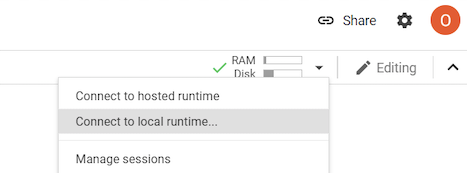

Before anything else we will create and set a working directory:

In [ ]:
# create a work directory and move into it
from epi2melabs import ping
tutorial_name = "isoform_tutorial"
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

working_dir = "/epi2melabs/{}/".format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/isoform_tutorial


### Install additional software

This tutorial uses a couple of software packages that are not included in the default **EPI2ME Labs** server. Below we will install these tools using the `conda` package manager. 

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*



In [ ]:
!mamba install -q -y stringtie gffcompare gffread pychopper

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

### Sample Data

To get started we will download a modest *D. melanogaster* dataset to explore with the isoform tutorial. The workflow also requires a reference sequence and an annotation set.

The form below will download the sample data, reference sequence and annotations. To start the download click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
#@markdown **Download sample data** *(click to show)*
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

location='{}/pychopper_tutorial'.format(site)
filename = "Dmel.4.filt.fastq.gz"
!echo "Downloading sample data"
!wget -q -O sample_data.fastq.gz "$location"/"$filename" \
    && cecho success "✔ Downloaded" || cecho error "Failed"

# download reference and annotations
!echo "Downloading reference sequence"
!wget -q -O Drosophila_melanogaster.BDGP6.dna.toplevel.fa.gz \
    http://ftp.ensembl.org/pub/release-95/fasta/drosophila_melanogaster/dna/Drosophila_melanogaster.BDGP6.dna.toplevel.fa.gz \
    && cecho success "✔ Downloaded" || cecho error "Failed"
!echo "Downloading annotation file"
!wget -q -O Drosophila_melanogaster.BDGP6.95.gtf.gz \
    http://ftp.ensembl.org/pub/release-95/gtf/drosophila_melanogaster/Drosophila_melanogaster.BDGP6.95.gtf.gz \
    && cecho success "✔ Downloaded" || cecho error "Failed"

✔ Downloaded
✔ Downloaded
✔ Downloaded


### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `input_file` variable below. To find the correct full path of a file you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

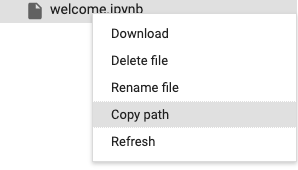

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data Entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.

The input files may be gzip compressed (and end in the `.gz` suffix). Along with the input files and option is provided to rebuild the alignment index (`rebuild_index`) and specify the number of compute threads (`threads`) to use during computations.

> *A annotation is required only for the final comparison, it is not integral to the workflow.*

Take care in selecting the **`read_type`**.  The `pychopper` tool (used for orienting and identifying full length transcripts) is run only on **cDNA** reads; **direct RNA** reads do not have the required adapters to perform this step. The sample data provided with this tutorial is a cDNA analyte.

If you are rerunning this workflow and wish to rebuild any minimap2 index within the workflow please tick **`rebuild_index`**. By default if the index is 
found to already exist, indexing reference step will be skipped.

In [ ]:
#@markdown **Analysis parameters**
import errno
import os

read_type = "cDNA" #@param ["cDNA", "dRNA"]
fastq = "sample_data.fastq.gz" #@param {type: "string"}
reference = "Drosophila_melanogaster.BDGP6.dna.toplevel.fa.gz" #@param {type: "string"}
annotations = "Drosophila_melanogaster.BDGP6.95.gtf.gz" #@param {type: "string"}
analysis_folder = "analysis" #@param {type: "string"}
threads =  48#@param {type: "integer"}
#@markdown Force rebuild any minimap2 index:
rebuild_index = False #@param {type: "boolean"}

!mkdir -p $analysis_folder
to_normalise = zip(
    ('fastq', 'reference', 'annotations'),
    (os.path.basename(x) for x in (fastq, reference, annotations)))

print("Checking files:")
inputs = dict()

run_pychopper = read_type == "cDNA"


def ensure_path(path):
  """
  Raise error is path doesn't exist
  """
  if not os.path.exists(path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), path)
  return True


def return_filepath(path):
  """
  Takes a filepath. If filepath is gzipped (has .gz) extensions then file
  is extracted and extracted path is returned. If filepath has gz extension
  and doesn't exist but the extracted version exists, return that path. If 
  extracted version of file or path (if not gzipped) raise FileNotFoundError.
  """
  if path.endswith(".gz"):
    extracted = os.path.splitext(path)[0]
    if os.path.exists(path):
      !echo "* Unzipping $path" && gunzip -f $path
    else:
      print("* Extracted file found: {}".format(extracted))
    path = extracted
  ensure_path(path)
  return path


for file_type, path in to_normalise:
  print("Checking {}: {}".format(file_type, path))
  if file_type == "annotations" and not path:
    print("* SKIPPING: No annotation file given")
    continue
  path = return_filepath(path)
  inputs[file_type] = path

print("Creating processed fastq folder")
processed_reads_dir = "processed_reads"
!mkdir -p $processed_reads_dir
print("Linking input_fastq to processed reads dir.")
input_fastq = inputs["fastq"]
!ln -s `realpath $input_fastq` $processed_reads_dir/input_reads.fq 2> /dev/null

Checking files:
Checking fastq: sample_data.fastq.gz
* Unzipping sample_data.fastq.gz
Checking reference: Drosophila_melanogaster.BDGP6.dna.toplevel.fa.gz
* Unzipping Drosophila_melanogaster.BDGP6.dna.toplevel.fa.gz
Checking annotations: Drosophila_melanogaster.BDGP6.95.gtf.gz
* Unzipping Drosophila_melanogaster.BDGP6.95.gtf.gz
Creating processed fastq folder
Linking input_fastq to processed reads dir.


### Sequence data quality control and pre-processing

Before we begin the analysis it is important to take an overview of the data with which we will be working.

>For more detail please see the [Introduction to fastq](https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/fastq_introduction.ipynb#scrollTo=7XgSmykutHVY) epi2me-labs tutorial.

The below code-block will perform a simple summary of the input single-molecule reads and display graphs depicting the read and base quality and their lengths. Read qualities are expected to be >10; read lengths will be dependent on your experiments but should mostly correspond to the expected transcript length distribution.

In [ ]:
#@markdown **Basic read QC graphs**  *(click to show)*
import aplanat
from aplanat.hist import histogram
from bokeh.layouts import gridplot
import numpy as np
from pysam import FastxFile

qualities = list()
mean_qualities = list()
lengths = list()

input_reads = os.path.join(processed_reads_dir, "input_reads.fq")
# open the file and iterate through its records
with FastxFile(input_reads) as fq:
    for rec in fq:
        # ONT calculation for "mean Q score"
        quals = np.fromiter(
            (ord(x) - 33 for x in rec.quality),
            dtype=int, count=len(rec.quality))
        mean_p = np.mean(np.power(10, quals/-10))
        mean_qualities.append(-10*np.log10(mean_p))
        # all qualities
        qualities.extend(quals)
        lengths.append(len(quals))


p1 = histogram(
    [np.array(mean_qualities)], title="Read quality scores",
    x_axis_label="quality", y_axis_label="count",
    height=250, width=300)
p2 = histogram(
    [qualities], title="Base quality scores",
    x_axis_label="quality", y_axis_label="count",
    height=250, width=300)
p3 = histogram(
    [lengths], title="Read lengths",
    x_axis_label="read length / bases", y_axis_label="count",
    height=250, width=300)
aplanat.show(gridplot((p1, p2, p3), ncols=3))

## Identifying and orienting full length transcripts

If we are dealing with cDNA reads (`read_type` specified above) we can classify, trim and orient the sequencing data. To do this we will use the `cdna_classifier.py` software from `pychopper`. This is a standard step in long read cDNA pipelines and makes subsequent steps easier.

***If you performed a direct RNA sequencing experiment please nevertheless run the code-block below as it will setup necessary inputs for subsequent steps.***

In order to check the validity of the pychopper results, a plot will be displayed illustrating the selection of the classification decision boundary. This plot should be unimodal (have a single peak).



In [ ]:
#@markdown **Running pychopper** *(click to show)*
import os
import pandas as pd
import aplanat
from aplanat import lines
full_length_reads = os.path.join(processed_reads_dir, "full_length_reads.fq")

# Run pychopper
if run_pychopper:
  !cd $processed_reads_dir && \
  cdna_classifier.py \
      -t $threads \
      -S "cdna_classifier_report.tsv" \
      "input_reads.fq" \
      "full_length_reads.fq"
  csv = os.path.join(processed_reads_dir, "cdna_classifier_report.tsv")

  df = pd.read_csv(csv, sep="\t", index_col="Name")
  classified = df.loc[df["Category"] == "Classification"] \
      .copy().reset_index().rename(columns={'Name': 'Classification'})
  classified["Percentage"] = 100 * classified["Value"] / classified["Value"].sum()
  display(classified[['Classification', 'Percentage',]])

  tuning =  df.loc[df["Category"] == "AutotuneSample"] \
      .copy().reset_index().rename(columns={'Name': 'Filter'})
  plot = lines.line(
      [tuning['Filter'].astype(float)], [tuning['Value']],
      title="Cut off parameter selection curve",
      x_axis_label='Filter cut off',
      y_axis_label='Selected reads')
  aplanat.show(plot)
else:
  !ln -s `realpath $processed_reads_dir/input_reads.fq` $full_length_reads 2> /dev/null
  print("Skipping: Running pychopper")



Configurations to consider: "+:SSP,-VNP|-:VNP,-SSP"
Counting fastq records in input file: input_reads.fq
Total fastq records in input file: 15076
Tuning the cutoff parameter (q) on 10024 sampled reads (66.3%) passing quality filters (Q >= 7.0).
Optimizing over 30 cutoff values.
100%|███████████████████████████████████████████| 30/30 [03:55<00:00,  7.84s/it]
Best cutoff (q) value is 0.5173 with 81% of the reads classified.
Processing the whole dataset using a batch size of 314:
100%|████████████████████████████████████| 15076/15076 [00:21<00:00, 712.78it/s]
Finished processing file: input_reads.fq
Input reads failing mean quality filter (Q < 7.0): 0 (0.00%)
Output fragments failing length filter (length < 50): 0
Detected 1 potential artefactual primer configurations:
Configuration	NrReads	PercentReads
VNP,SSP,-SSP	152	1.01%


,Classification,Percentage
0,Primers_found,80.322813
1,Rescue,2.125845
2,Unusable,17.551342


## Mapping reads to the reference

With our reads QCed, we proceed by aligning the data to the provided reference. We will use `minimap2` to perform this task using its *splice aware* mode. This allows reads to be split across introns and span exons. Once minimap2 is finished we process the alignment (`.bam`) file, filter, sort and generate an index (`.bai`). Filtering is used to remove secondary and supplementary alignments and those below the minimum mapping quality threshold (specified below - default Q40).

> **A note on alignment filtering:** the alignment file is filtered such that *secondary* and *supplementary* alignments are removed. The correct placement of a read may be ambiguous, for example from the presence of repeats in the genome. In this case there may be multiple read alignments for the same read. One of these alignments is considered primary. All the other alignments have the secondary alignment flag set. Some alignments of reads cannot be represented as a simple linear alignment. These *chimeric alignments* are represented as a set of linear alignments that do not have large overlaps. Typically one of the linear alignments in a chimeric alignment is considered the “representative” alignment, and the others are called “supplementary”.

Sensible defaults have been selected for these advanced minimap2 parameters but feel free to change these for your specific experiment. A secondary filtering step is performed based on reasonable expectations of transcript data:

* **`min_mapping_quality`**: reads below this mapping quality will be disgarded. The higher this parameter, the more reads will be discarded.
* **`max_poly_run`**: maximum allowed poly(A) length in the genome near the 3' end of mapping.
* **`poly_context`**: internal priming filter context size

This section will generate the following files in the **`alignments/`** directory:
* **`reads_aln_sorted.bam`** - alignment of the processed reads against the chosen reference.
* **`reads_aln_sorted.bam.bai`** - index file for the alignment
* **`reads_aln_sorted.bam.tsv`** - tsv representation of the alignment including accuracy, identity and coverage.


In [ ]:
#@markdown **Alignment and filtering with `minimap2`** *(click to show)*
import yaml
min_mapping_quality = 40 #@param {type: "integer"}

#@markdown Secondary filtering
poly_context = 24 #@param {type: "integer"}
max_poly_run = 8  #@param {type: "integer"}
context_plot_alignments = 5000 #@param {type: "integer"}

alignments_dir = os.path.join(analysis_folder, 'alignments')

# create minimap index
index_dir = os.path.join(analysis_folder, 'index')
!mkdir -p $index_dir
ref = inputs['reference']
minimap_index = os.path.join(index_dir, "genome_index.mmi")
if rebuild_index or not os.path.exists(minimap_index):
    print("* Building minimap index...")
    !minimap2 -t $threads -k14 -I 1000G -d $minimap_index $ref \
    && echo "✓ Built index!"
else:
    print("* Skipping building minimap index")

!mkdir -p $alignments_dir
minimap_out_bam = os.path.join(alignments_dir, "reads_aln_sorted.bam")
unfiltered_sam = os.path.join(alignments_dir, "unfiltered.sam")

filtered_tsv = os.path.join(alignments_dir, "internal_priming_fail.tsv")
context_filt = {
    "AlnContext": {
        "Ref": ref,
        "LeftShift": -poly_context,
        "RightShift": poly_context,
        "RegexEnd": "[Aa]{{{pr},}}".format(pr=max_poly_run),
        "Stranded": True,
        "Invert": True,
        "Tsv": filtered_tsv}}
with open('filt.yaml', 'w') as outfile:
    yaml.dump(context_filt, outfile)

!rm -rf $minimap_out_bam
!minimap2 -t $threads -ax splice -uf $minimap_index $full_length_reads \
    | samtools view -q $min_mapping_quality -F2304 -bS - \
    | seqkit_bam_yaml filt.yaml \
    | samtools sort -@ $threads -o $minimap_out_bam -
!samtools index $minimap_out_bam

* Building minimap index...
[M::mm_idx_gen::3.426*1.22] collected minimizers
[M::mm_idx_gen::6.173*1.40] sorted minimizers
[M::main::29.430*0.42] loaded/built the index for 1870 target sequence(s)
[M::mm_idx_stat] kmer size: 14; skip: 10; is_hpc: 0; #seq: 1870
[M::mm_idx_stat::29.648*0.42] distinct minimizers: 13579029 (67.42% are singletons); average occurrences: 1.953; average spacing: 5.419
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -t 48 -k14 -I 1000G -d analysis/index/genome_index.mmi Drosophila_melanogaster.BDGP6.dna.toplevel.fa
[M::main] Real time: 29.689 sec; CPU: 12.634 sec; Peak RSS: 1.085 GB
✓ Built index!
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::1.549*0.76] loaded/built the index for 1870 target sequence(s)
[M::mm_mapopt_update::1.873*0.80] mid_occ = 133
[M::mm_idx_stat] kmer size: 14; skip: 10; is_hpc: 0; #seq: 1870
[M::mm_idx_stat::2.071*0.82] distinct minimizers: 13579029 (67.42% are singletons)

As a brief sanity check of the alignments, we can summarise the information
contained within the alignment `.bam` file and check some basic statistics. The code below will plot a read accuracy histogram together with a histogram depicting the proportion of each read contained within its alignment. This second plot should show a strong peak >98% indicating that the reads align to the reference across their full length.

In [ ]:
#@markdown **Read summary plot code** *(click to show)*
# calculate some basic statistics from the alignments
!stats_from_bam -o $minimap_out_bam'.tsv' $minimap_out_bam
#2> /dev/null

from aplanat import hist
from bokeh.layouts import gridplot
df = pd.read_csv(minimap_out_bam + '.tsv', sep="\t")

p1 = hist.histogram(
    [df['acc']], xlim=(70,101), binwidth=0.5, height=200,
    x_axis_label='read accuracy', y_axis_label='read count')
p2 = hist.histogram(
    [df['coverage']], xlim=(90,101), binwidth=0.2, height=200,
    x_axis_label='% of read contained in alignment',
    y_axis_label='read count')

aplanat.show(gridplot([[p1], [p2]]))

Mapped/Unmapped/Short/Masked: 12084/0/0/0


### Assembling reads into transcripts

We will now run [StringTie](https://ccb.jhu.edu/software/stringtie/) to assemble RNA-Seq reads into potential transcripts.

This step sill produce one or more [GFF](https://en.wikipedia.org/wiki/General_feature_format) which are then consolidated in the single output file `annotation/stringtie.gff`.

> The `split_bam` option here will aid computational performance but may lead to less accurate results than otherwise.

In [ ]:
#@markdown **Assemble transcripts with StringTie** *(click to show)*
import glob

bam_bundle_dir = "bam_bundles"
min_reads = 50000 #@param {type: "integer"}
split_bam = True #@param {type: "boolean"}

# make bam bundles to speed calculation
!rm -rf $bam_bundle_dir
if split_bam:
    !seqkit bam -j $threads -N $min_reads $minimap_out_bam -o $bam_bundle_dir
else:
    !mkdir -p bam_bundle_dir
    !ln -s $minimap_out_bam $bam_bundle_dir'/000000000_ALL:0:1_bundle.bam'

# use_guide = True #@param {type: "boolean"}
bam_paths = os.path.join(bam_bundle_dir, "*")
gff_bundle_dir = "gff_bundles"

for bam_path in glob.glob(bam_paths):
  bam_name = os.path.splitext(os.path.basename(bam_path))[0]
  label = "STR.{}.".format(int(bam_name.split("_")[0]))
  gff = "{}/{}.gff".format(gff_bundle_dir, bam_name)
  g_flag = ""
  if inputs["annotations"]:
      g_flag = '-G {}'.format(inputs["annotations"])
  !stringtie --rf $g_flag  -l "$label" -L -v -p "$threads" --conservative -o "$gff" "$bam_path"

# merge gff bundles into a single file:
#  `results/annotation/str_merged.gff`
annotation_dir = os.path.join("results", "annotation")
!mkdir -p $annotation_dir
stringtie_gff = os.path.join(annotation_dir, "stringtie.gff")
!rm stringtie_gff 2>/dev/null
paths = glob.glob(os.path.join(bam_bundle_dir, "*.bam"))
bundle = [os.path.splitext(os.path.basename(path))[0] for path in paths]
bundle = sorted(bundle, key=lambda x: int(x.split("_")[0]))
gffs = [os.path.join(gff_bundle_dir, "{}.gff".format(name)) for name in bundle]
for gff in gffs:
    !grep -v '#' "$gff" >> $stringtie_gff

[INFO] Creating BAM bundles from file: analysis/alignments/reads_aln_sorted.bam
[INFO] Minimum reads per bundle: 50000
[INFO] Output directory: bam_bundles
Bundle	Chrom	Start	End	NrRecs	NrLoci
0	mitochondrion_genome	3125	13579	12084	107
[INFO] Written 12084 BAM records to 107 loci and 1 bundles.
Running StringTie 2.1.2. Command line:
stringtie --rf -G Drosophila_melanogaster.BDGP6.95.gtf -l STR.0. -L -v -p 48 --conservative -o gff_bundles/000000000_mitochondrion_genome:3125:13579_bundle.gff bam_bundles/000000000_mitochondrion_genome:3125:13579_bundle.bam
[07/30 14:49:24] Loading reference annotation (guides)..
[07/30 14:49:27] 34767 reference transcripts loaded.
Default stack size for threads: 8388608
[07/30 14:49:27]>bundle 2L:2745098-2758176 [1 alignments (1 distinct), 4 junctions, 11 guides] begins processing...
[07/30 14:49:27]>bundle 2L:7740562-7741537 [1 alignments (1 distinct), 2 junctions, 1 guides] begins processing...
[07/30 14:49:27]>bundle 2L:8363477-8364662 [1 alignments (

## Comparison to existing annotation

The transcriptome generated by the above workflow can be compared to an existing genome annotation. One result from this analysis can be the discovery of novel transcripts not present in the reference databases.

To create a comparison between the reference annotations and the transcriptome produced by the above workflow we can use `gffcompare`.

> This will only run if an annotation file was supplied at the beginning of this notebook.

This step will produce the following files in the `results/gffcompare` directory:
* **`stringtie.annotated.gtf`**: a [GTF](https://en.wikipedia.org/wiki/Gene_transfer_format) file containing the transcripts assembled by Stringtie an annotated with the reference annotation informaiton.
* **`stringtie.tracking`**: a tabular summary file containing the annotation status of the transcripts.

In [ ]:
#@markdown **Annotating assembled transcripts**  *(click to show)*

annotations = os.path.abspath(inputs["annotations"])
gff_compare_dir = os.path.join("results", "gffcompare")
!mkdir -p "$gff_compare_dir"
annotated_gff = os.path.join(gff_compare_dir, "stringtie.annotated.gtf")

if annotations:
    !gffcompare -o "$gff_compare_dir"/stringtie -r "$annotations" -R "$stringtie_gff" \
        && cecho success "✓ Completed gffcompare" \
        || cecho error "✗ Failed gffcompare"
else:
    !cecho warning "Skipping comparison with annotation as none provided."

  34767 reference transcripts loaded.
  3271 duplicate reference transcripts discarded.
  119 query transfrags loaded.
✓ Completed gffcompare


Now that `gffcompare` has been run we can investigate the `.tracking` file produced. This gives details on the comparison between the reference annotation and the new annotation produced by this analysis above. A reference guide to the transcript classifications can be found [here](https://ccb.jhu.edu/software/stringtie/gffcompare.shtml#Transcript_classification_codes), though the following table highlights the key details. In *general* novel transcripts will be marked as `u` for unknown.





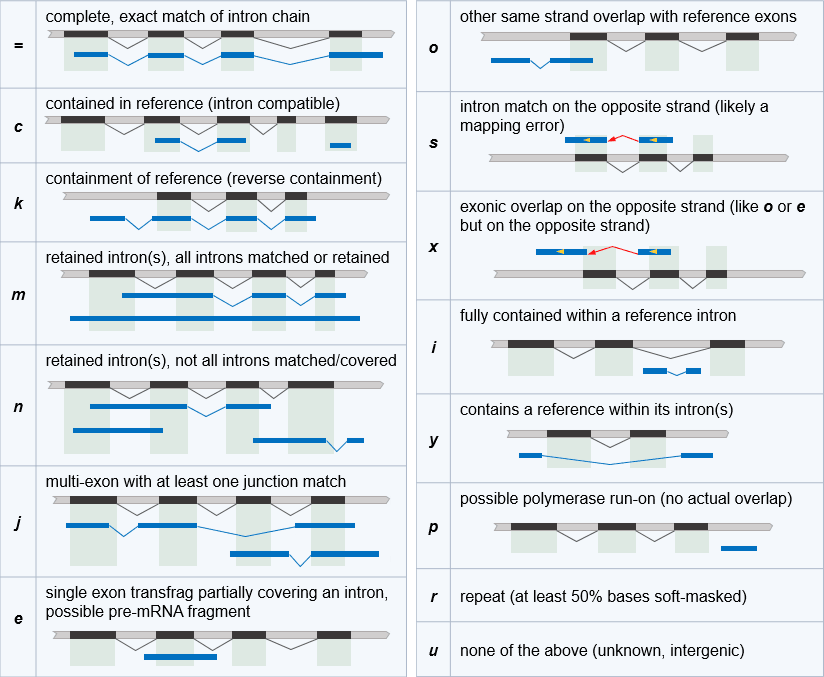

Using the `.tracking` file we can summarise the classifications found.  A TSV will be created in the `results/gffcompare/` directory per possible classification.  By default a TSV will be created per classification code even if there are no transcripts within that category.  

In [ ]:
#@markdown **Classification summary** *(click to show)*

write_empty_tsvs = False
tracking_headings = [
    "query_transfrag_id", "query_locus_id", "ref_gene_id",
    "class", "details"]
nice_names = {
    '=': 'complete', 'c': 'contained', 'k': 'containment',
    'm': 'retained', 'n': 'retained (partial)', 'j': 'multi',
    'e': 'single', 'o': 'overlap', 's': 'opposite',
    'x': 'exonic', 'i': 'intron', 'y': 'contains', 'p': 'runon',
    'r': 'repeat', 'u': 'unknown'}

tracking_file = os.path.join(
    gff_compare_dir, "stringtie.tracking")
if os.path.exists(annotations):
    tracking = pd.read_csv(
        tracking_file, sep="\t", names=tracking_headings[1:],
        index_col=0)

    d = pd.DataFrame(tracking['class'].value_counts()) \
        .reset_index().rename(columns={'index':'class', 'class':'count'})
    d['description'] = [nice_names[x] for x in d['class']]
    display(d)
    
    # write a separate table for each class
    for class_code, table in tracking.groupby('class'):
      if not write_empty_tsvs and table.empty:
        print("Skipping: No transcripts found for: {}".format(class_code))
        continue
      
      path = tracking_file + ".{}.tsv".format(class_code)
      table.to_csv(path)
else:
    !cecho warning "Skipping classification summary as no annotation provided."

,class,count,description
0,=,51,complete
1,c,33,contained
2,j,22,multi
3,s,2,opposite
4,n,2,retained (partial)
5,u,2,unknown
6,o,2,overlap
7,e,2,single
8,m,1,retained
9,p,1,runon


### Generating a transcriptome

We now have our finalised transcripts, either straight from the StringTie assembler or having been annotated. To create a transcriptome from this output we can use `gffread` to combine it with the genomic reference sequence.

In [ ]:
#@markdown **Create transcriptome** *(Click to show)*
stringtie_transcriptome = os.path.join("results", "stringtie_transcriptome.fas")

ref = inputs['reference']
if os.path.exists(annotated_gff):
    !cecho ok "Creating transcriptome with annotations"
    !gffread -F -g "$ref" -w $stringtie_transcriptome $annotated_gff
    !echo "Done"
else:
    !cecho warning "Creating transcriptome without annotations"
    !gffread -g "$ref" -w "$stringtie_transcriptome" "$stringtie_gff"
    !echo "Done"

Creating transcriptome with annotations
FASTA index file Drosophila_melanogaster.BDGP6.dna.toplevel.fa.fai created.
Done


# Summary

In this tutorial we have worked through analysis of Oxford Nanopore Technologies' sequencing data. We first performed some basic QC on the reads. If the reads were cDNA then full length reads were identified, trimmed and oriented using pychopper.  The reads were then aligned to a reference genome and assembled using StringTie to create transcripts.

If an existing annotation was provided the assembled transcripts were annotated, in so far as any known transcripts were labelled as such and novel transcripts were identified.

In a final step we created a transcriptome using the assembled transcripts and the reference genome.

The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
